In [1]:
import pandas as pd
import numpy as np
import math
import glob
import datetime
import time
from itertools import groupby

In [2]:
def clump_array(a):

    """
    Split array for arrays w/o NaN
    """

    return [np.float64(a[s]) for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

In [3]:
clump_test = np.array([1, 2, 3, np.NaN, np.NaN, 5, 6, 6, np.NaN, 3, 4])
clump_array(clump_test)

[array([1., 2., 3.]), array([5., 6., 6.]), array([3., 4.])]

In [4]:
clump_test_2 = [1, 2, 3, 4, 5, 6]
clump_array(clump_test_2)

[array([1., 2., 3., 4., 5., 6.])]

In [5]:
import numba

"""
Calculation only applicable to array w/o NaN. 
If some exist an array is splitting with function called clump_array

BFI calculation will be applied to every clump independently

"""
###################################################################

"""
First pass

"""
@numba.jit(nopython = True)
def FirstPass(Q, alpha):
    
    q_f_1 = [np.float64(np.NaN) for i in Q]
    q_b_1 = [np.float64(np.NaN) for i in Q]
    
    q_f_1[0] = Q[0]

    for j in range(len(Q)-1):
        """
        for every split calculate quick flow

        """
        q_f_1[j+1] = alpha * q_f_1[j] + 0.5 * (1 + alpha) * (Q[j+1] - Q[j])

    for j in range(len(Q)):
        if q_f_1[j] < 0:
            q_b_1[j] = Q[j]
        else:
            q_b_1[j] = Q[j] - q_f_1[j]

    Q_forward_1 = [q_f_1, q_b_1]
    
    return Q_forward_1

###################################################################
"""
Backward pass

"""
@numba.jit(nopython = True)
def BackwardPass(Q_forward_1, alpha):

    """
    Q - n-dimensional list depend on the number of clumps
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [np.float64(np.NaN) for i in Qq]
    q_b_2 = [np.float64(np.NaN) for i in Qb]


    "last value of forward step - first in backward step"
    
    q_f_2[-1] = Qb[-1]

    for j in range(len(Qq)-2, -1, -1):
        q_f_2[j] = alpha * q_f_2[j+1] + 0.5 * (1 + alpha) * (Qb[j] - Qb[j+1])

    for j in range(len(Qq)-1, -1, -1):
        if q_f_2[j] < 0:
            q_b_2[j] = Qb[j]
        else:
            q_b_2[j] = Qb[j] - q_f_2[j]
                
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################
"""
Forward pass

"""
@numba.jit(nopython = True)
def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [np.float64(np.NaN) for i in Qq]
    q_b_3 = [np.float64(np.NaN) for i in Qb]


    "Now first value of previous step - first here as well"

    q_f_3[0] = Qb[0]

    for j in range(len(Qb)-1):

        q_f_3[j+1] = alpha * q_f_3[j] + 0.5 * (1 + alpha) * (Qb[j+1] - Qb[j])

    for j in range(len(Qb)):
        if q_f_3[j] < 0:
            q_b_3[j] = Qb[j]
        else:
            q_b_3[j] = Qb[j] - q_f_3[j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################
"""
BFI calculations for given alpha

"""
@numba.jit(nopython = True)
def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    Qin = Q
    
    "reflect our lists"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    if len(Q)-1 > reflect:
        Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
        Qbase = [0 if j < 0 else j for j in Qbase]
    else:
        Qbase = Q1[1]
        Qbase = [0 if j < 0 else j for j in Qbase]

    bfi = 0
    mean_for_period = 0
    
    if np.mean(Qin) == 0:
        bfi = 0
    else:
        for j in Qbase:
            mean_for_period += j/np.mean(Qin)
        bfi = mean_for_period/len(Qbase)

    return bfi, Qbase

"""
BFI calculations for 1000 alpha between 0.9 and 0.98

"""

import random
@numba.jit(nopython = True)
def BFI_calc_1000(Q, passes, reflect):
    """
    Calculation was made for 1000 random splitted alpha in 
    range of 0.9 to 0.98
    
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    random.seed(1996)
    alpha_coefficients = [np.float64(random.uniform(0.9, 0.98)) for i in range(1000)]
    
    Q = np.array([np.float64(i) for i in Q], dtype = np.float64)
    Qin = Q
    
    "reflect our lists"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    bfi_record = []
    Qbase_record = []
    
    for i, alpha in enumerate(alpha_coefficients):
        
        Q1 = FirstPass(Q_reflect, alpha)

        "how many backwards/forward passes to we need © Anthony Ladson"

        n_pass = round(0.5 * (passes -1))

        BackwardPass(Q1, alpha)

        for i in range(n_pass):
            Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)
        

        ################# end of passes  ##############################
        if len(Q)-1 > reflect:
            Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
            Qbase = [0 if j < 0 else j for j in Qbase]
        else:
            Qbase = Q1[1]
            Qbase = [0 if j < 0 else j for j in Qbase]
        
        Qbase_record.append(np.array(Qbase, dtype=np.float64))
        
        bfi = 0
        mean_for_period = 0

        if np.mean(Qin) == 0:
            bfi = 0
        else:
            for j in Qbase:
                mean_for_period += j/np.mean(Qin)
            bfi = mean_for_period/len(Qbase)
            
        bfi_record.append(np.float64(bfi))
        
    """
    After 1000 calculations function return
    mean value out of 1000
    
    And "mean" hygrograph of baseflow
    
    """
    
    # mean BFI out of 1000
    
    bfi_mean = 0
    for i in bfi_record:
        bfi_mean += i
    bfi_mean = bfi_mean/len(bfi_record)
    
    # mean hydrograph out of 1000 calculations

    Qbase_mean = [np.float64(0) for i in range(len(Qbase))]
    
    for Qbase_temp in Qbase_record:
        for i, value in enumerate(Qbase_temp):
            Qbase_mean[i] += value
    
    Qbase_mean = [np.float64(i/len(Qbase_record)) for i in Qbase_mean]
        
    return bfi_mean, Qbase_mean

### Dont activate lower function if you run the one above

In [53]:
###################################################################


def FirstPass(Q, alpha):

    q_f_1 = [[[] for _ in range(len(i))] for i in Q]
    q_b_1 = [[[] for _ in range(len(i))] for i in Q]

    for i in range(len(Q)):           
        """
        We set the first values to the vector of "fast" flow

        """
        q_f_1[i][0] = Q[i][0]

        for j in range(len(Q[i])-1):
            """
            For each piece calculate the fast runoff

            """
            q_f_1[i][j+1] = alpha * q_f_1[i][j] + 0.5 * (1 + alpha) * (Q[i][j+1] - Q[i][j])

        for j in range(len(Q[i])):
            if q_f_1[i][j] < 0:
                q_b_1[i][j] = Q[i][j]
            else:
                q_b_1[i][j] = Q[i][j] - q_f_1[i][j]
    
    Q_forward_1 = [q_f_1, q_b_1]
    
    return q_f_1, q_b_1

###################################################################

def BackwardPass(Q_forward_1, alpha):

    """
    Q - n-dimensional list depend on the number of clumps
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_2 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):
        "last value of forward step - first in backward step"
        q_f_2[i][-1] = Qb[i][-1]

        for j in range(len(Qq[i])-2, -1, -1):
            q_f_2[i][j] = alpha * q_f_2[i][j+1] + 0.5 * (1 + alpha) * (Qb[i][j] - Qb[i][j+1])

        for j in reversed(range(len(Qq[i]))):
            if q_f_2[i][j] < 0:
                q_b_2[i][j] = Qb[i][j]
            else:
                q_b_2[i][j] = Qb[i][j] - q_f_2[i][j]
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################

def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_3 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):

        "Now first value of previous step - first here as well"

        q_f_3[i][0] = Qb[i][0]

        for j in range(len(Qb[i])-1):

            q_f_3[i][j+1] = alpha * q_f_3[i][j] + 0.5 * (1 + alpha) * (Qb[i][j+1] - Qb[i][j])

        for j in range(len(Qb[i])):
            if q_f_3[i][j] < 0:
                q_b_3[i][j] = Qb[i][j]
            else:
                q_b_3[i][j] = Qb[i][j] - q_f_3[i][j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################

def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    Qin = Q
    
    "reflect our lists"
    
    Q_reflect = [[[] for _ in range(len(i) + 2 * reflect)] for i in Q]

    for i in range(len(Q_reflect)):

        Q_reflect[i][:reflect] = Q[i][(reflect):0:-1] #добавляем 

        Q_reflect[i][(reflect):(reflect + len(Q[i]))] = Q[i]

        Q_reflect[i][(reflect + len(Q[i])):(len(Q[i]) + 2 + 2 * reflect)] = Q[i][len(Q[i])-2:len(Q[i]) - reflect - 2:-1]
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    
    Qbase = [i[reflect:(len(i)-reflect)] for i in Q1[1]]
    Qbase = [[0 if j < 0 else j for j in i] for i in Qbase]
    
    # расчёт взвешенного среднего для разбитого на куски ряда расходов
    
    len_Qbase = len([item for sublist in Qbase for item in sublist]) # длина всех расходов, без учёта пропусков
    weights_for_average = [len(i)/len_Qbase for i in Qbase] # вес для среднего по каждому элементу
    
    weighted_bfi = np.sum([weights_for_average[i] * np.nanmean(Qbase[i]/np.nanmean(Qin[i])) if np.nanmean(Qin[i]) != 0 else weights_for_average[i] * 0 for i in range(len(Qbase))]) #взвешенное среднее по выпуклой комбинации

    return weighted_bfi, Qbase

### Test functions on dataset provided by Anthony Ladson in original paper

In [6]:
import requests
import csv
url = "https://raw.github.com/TonyLadson/data/master/data/BassRiver@Loch.csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)

my_list = [np.float64(i[0]) for i in my_list]

In [7]:
t = BFI_calc_1000(np.array(my_list, dtype = np.float64), 3, 30)
t1 = BFI_calc(np.array(my_list, dtype = np.float64), 0.98, 3, 30)
print('BFI on random values from 0.9 to 0.98 = {}, BFI on alpha 0.98 = {}'.format(t[0], t1[0]))

BFI on random values from 0.9 to 0.98 = 0.35213351185633607, BFI on alpha 0.98 = 0.1965758714772886


In [8]:
test = pd.DataFrame({'Q':my_list, 'Baseflow': t[1]})

<AxesSubplot:>

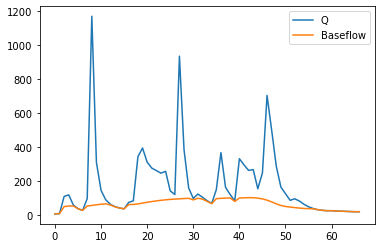

In [10]:
test.plot()

### Assume if we had NaN in our list

In [11]:
from copy import deepcopy
my_list_nan = deepcopy(my_list)
my_list_nan[5:12] = [np.NaN for _ in range(len(my_list_nan[5:12]))]
my_list_nan = pd.DataFrame({'Q':my_list_nan})
clump_array(my_list_nan.Q.to_numpy())

[array([  5.,   7., 108., 117.,  57.]),
 array([ 62.,  48.,  40.,  35.,  73.,  82., 342., 393., 310., 275., 260.,
        245., 256., 141., 119., 934., 382., 158.,  96., 122., 103.,  83.,
         67., 148., 366., 161., 119.,  82., 330., 294., 261., 266., 153.,
        247., 703., 498., 286., 163., 124.,  85.,  94.,  81.,  62.,  47.,
         37.,  30.,  26.,  24.,  24.,  22.,  21.,  20.,  19.,  18.,  18.])]

In [12]:
def bfi_recover(year_of_observation, bfi_values):
    
        """
        Restoring the baseflow row taking into account the previously "knocked out" gaps
        
        """
        Qbase_full = [list(group) for key, group in groupby(year_of_observation.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
        mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

        position_index = -1
        for j, mask in enumerate(mask_to_refill):
            """
             Since the primary cut sheet from the clumped_array function has the same number of sheets as True, we restore in accordance

             The position_index argument is selected according to the presence with True and addresses the desired chunk in Qbase

             Everything is overwritten in the sheet, where in the overwritten values the drain values are equivalent in length
            """
            if len(Qbase_full) > 1:
                if mask:
                    position_index += 1
                    Qbase_full[j] = bfi_values[position_index]
                else:
                    position_index = position_index
                    Qbase_full[j] = Qbase_full[j]
            else:
                Qbase_full[j] = [item for sublist in bfi_values for item in sublist]

        if len(Qbase_full) > 1:
            Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN
        else:
            Qbase_full = [item for sublist in Qbase_full for item in sublist]

        return Qbase_full

In [13]:
def bfi_recover(year_of_observation, bfi_values):
    
        """
        Restoring the baseflow row taking into account the previously "knocked out" gaps
        
        """
        Qbase_full = [list(group) for key, group in groupby(year_of_observation.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
        mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

        position_index = -1
        for j, mask in enumerate(mask_to_refill):
            """
             Since the primary cut sheet from the clumped_array function has the same number of sheets as True, we restore in accordance

             The position_index argument is selected according to the presence with True and addresses the desired chunk in Qbase

             Everything is overwritten in the sheet, where in the overwritten values the drain values are equivalent in length
            """
            if len(Qbase_full) > 1:
                if mask:
                    position_index += 1
                    Qbase_full[j] = bfi_values[position_index]
                else:
                    position_index = position_index
                    Qbase_full[j] = Qbase_full[j]
            else:
                Qbase_full[j] = [item for sublist in bfi_values for item in sublist]

        if len(Qbase_full) > 1:
            Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN
        else:
            Qbase_full = [item for sublist in Qbase_full for item in sublist]

        return Qbase_full

In [14]:
"""
For more clumped lists we can run a loop
"""
Baseflow_for_Sequences = [BFI_calc(np.array(clump_array(my_list_nan.Q.to_numpy())[0], dtype = np.float64), 0.98, 3, 30)[1], BFI_calc(np.array(clump_array(my_list_nan.Q.to_numpy())[1], dtype = np.float64), 0.98, 3, 30)[1]]
BFI_for_Sequences = [BFI_calc(np.array(clump_array(my_list_nan.Q.to_numpy())[0], dtype = np.float64), 0.98, 3, 30)[0], BFI_calc(np.array(clump_array(my_list_nan.Q.to_numpy())[1], dtype = np.float64), 0.98, 3, 30)[0]]

In [15]:
test_with_nan = pd.DataFrame({'Q': my_list_nan.Q.to_numpy(),'Baseflow':bfi_recover(my_list_nan, Baseflow_for_Sequences)})

<AxesSubplot:>

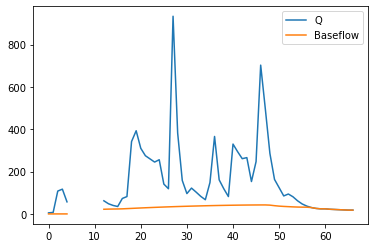

In [16]:
test_with_nan.plot()

In [17]:
def weighted_bfi(list_of_bfi, list_of_baseflows, len_of_array_w_nan):
    weights_of_clump = [[] for _ in list_of_bfi]
    clump_Qbase = [[] for _ in list_of_bfi]
    for i, clump in enumerate(list_of_baseflows):
        if type(clump) == list:
            weights_of_clump[i] = len(clump)/(len_of_array_w_nan)
            clump_Qbase[i] = list_of_baseflows[i]
        else:
            weights_of_clump[i] = np.NaN
            clump_Qbase[i] = np.NaN
    weighted_bfi = np.sum([bfi * weights_of_clump[j] for j, bfi in enumerate(list_of_bfi)])
    return weighted_bfi

### Weighted BFI for sequenced list

In [18]:
weighted_bfi(BFI_for_Sequences, Baseflow_for_Sequences, len(my_list_nan.Q.to_numpy()))

0.15405254154433876